In [91]:
from gensim.corpora import Dictionary
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string

In [92]:
# read with spark because of nested list column 
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

spark = SparkSession.builder.getOrCreate()
df = spark.read.parquet("long-parsed-tweets2")

In [93]:
df = df.where(df.lang == "en").sample(0.1)
df = df.withColumn("rt_indicator", when(df.full_text.like("RT @%"), 1).otherwise(0))
pdf = df.toPandas()

In [94]:
import re
def replace_entities(row):
    mentions = row['mentions']
    urls = row['urls']
    tweet = row['full_text']
    
    mentions = ['@' + m for m in mentions.split(' ')]
    for m in mentions:
        if len(m) > 0:
            tweet = tweet.replace(m, '@MENTION')
        
    urls = urls.split(' ')
    for u in urls:
        if len(u) > 0:
            tweet = tweet.replace(u, '@URL')
    http = re.compile(r'https?://\S+')
    tweet = http.sub('@URL', tweet)
        
    return tweet

In [95]:
pdf['cleaned_text'] = pdf.apply(replace_entities, axis=1)

In [96]:
from demoji import replace
import re
from gensim.parsing.preprocessing import strip_multiple_whitespaces, remove_stopwords
from gensim.utils import to_unicode
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS

STOPWORDS = STOPWORDS.union(stopwords.words('english')).union(set('&amp;'))
def my_remove_stopwords(s):
    s = to_unicode(s)
    s = s.lower()
    return " ".join(w for w in s.split() if w not in STOPWORDS)

def replacer(string):
    string = string.replace("-", "")
    string = string.replace("RT ", "")
    handles_and_hashtags = re.compile(r"[^\w\d#@\s]+")
    string =  handles_and_hashtags.sub('', string)
    return string

def ignore_stemmer(token_list):
    stemmed_list = []
    for t in token_list:
        if not t.startswith("@") and not t.startswith("#"):
            t = SnowballStemmer("english").stem(t)
        stemmed_list.append(t)
    return stemmed_list

custom_filters = [
                  strip_multiple_whitespaces,
                  replacer,
                  my_remove_stopwords
                 ]
pdf['cleaned_text'] = pdf.cleaned_text.apply(preprocess_string, filters=custom_filters)

def further_replacer(text_list):
    numbers = re.compile(r"\d+")
    new_text_list = []
    for w in text_list:
        if w == '@url':
            new_text_list.append('@URL')
            continue
            
        if w == '@mention':
            new_text_list.append('@MENTION')
            continue
            
        if numbers.match(w):
            new_text_list.append('@NUMBER')
            continue
            
        else:
            new_text_list.append(w)
    
    return new_text_list

pdf['cleaned_text'] = pdf.cleaned_text.apply(further_replacer)

In [97]:
pdf['cleaned_text'] = pdf.cleaned_text.apply(ignore_stemmer)

In [98]:
pdf["created_at"] = pd.to_datetime(pdf.created_at)

In [99]:
# need to confirm it's right to do dict with full text but other things not with it 
dictionary = Dictionary(pdf.cleaned_text.to_list())

training_df = pdf[pdf.rt_indicator == 0]

training_docs = training_df.cleaned_text.to_list()
training_corpus = [dictionary.doc2bow(tweet) for tweet in training_docs]

full_docs = pdf.cleaned_text.to_list()
full_corpus = [dictionary.doc2bow(tweet) for tweet in full_docs]



In [100]:
from gensim.models import ldamulticore
# main hyperparameter is number of topics, 10 may be too little, try 50 or 100 for this random sample dataset
# for coronavirus themed tweets, we could do fewer topics 

# Set training parameters.
# try different number of topics
num_topics = 10
chunksize = 2000 # number of documents passed to a core

# use defaults for iterations and passes and see if modeling is good
passes = 20 # number of passes through corpus
iterations = 400 # could make 100 for coronavirus tweets, but could reduce for faster development iterations 
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = ldamulticore.LdaMulticore(
    corpus=training_corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    iterations=400,
    num_topics=50,
    eval_every=eval_every
)

In [101]:
top_topics = model.top_topics(training_corpus)

In [103]:
topics = []
for i in range(len(full_corpus)):
    topics.append(model.get_document_topics(full_corpus[i], minimum_probability=0.0))

In [104]:
probabilities = []
for t in topics:
    p = list(zip(*t))[1]
    probabilities.append(p)

In [105]:
pdf['topics'] = probabilities

In [106]:
from scipy.stats import entropy
import math

def calculate_perplexity(probability_list):
    return math.exp(entropy(probability_list))

In [107]:
pdf['perplexity'] = pdf['topics'].apply(calculate_perplexity)

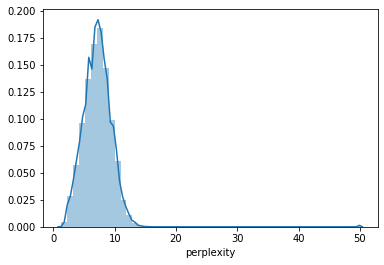

In [108]:
import seaborn as sns
sns.distplot(pdf['perplexity'])

In [109]:
# throw away tweets with perplexity too high
unperplexed = pdf[pdf['perplexity'] < 10]

In [110]:
import numpy as np
unperplexed['top_topic'] = pdf['topics'].apply(np.argmax)
unperplexed['top_topic_prob'] = pdf['topics'].apply(max)

/Users/samanthahoffman/miniconda3/envs/covid-tweets/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/samanthahoffman/miniconda3/envs/covid-tweets/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
unperplexed.to_csv("50_topic_model_round_3.csv")

In [112]:
text_dict = {}
for i in range(50):
    ordered = unperplexed.loc[unperplexed.topics.apply(lambda x: x[i]).sort_values(ascending = False).index]
    text_dict[i] = list(ordered.full_text.unique()[:10])

In [113]:
import json
with open("50_topics_tweets_round_3.json", "w") as f:
    f.write(json.dumps(text_dict, indent = 2, ensure_ascii = False))